In [1]:
%matplotlib inline

import torch
import torch.nn as nn

from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from elastic_weight_consolidation import ElasticWeightConsolidation

In [2]:
# Load MNIST data (with handwritten numbers = first task)
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

In [3]:
# Load Fashion MNIST data (with fashion items = second task)
f_mnist_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())
f_mnist_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())
f_train_loader = DataLoader(f_mnist_train, batch_size=100, shuffle=True)
f_test_loader = DataLoader(f_mnist_test, batch_size=100, shuffle=False)

In [4]:
# Define network architecture
class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, act='relu', use_bn=False):
        super(LinearLayer, self).__init__()
        self.lin = nn.Linear(input_dim, output_dim, bias=not use_bn)
        self.act = nn.ReLU() if act == 'relu' else act
        if use_bn:
            self.bn = nn.BatchNorm1d(output_dim, track_running_stats=False)
        else:
            self.bn = None
    
    def forward(self, x):
        y = self.lin(x)
        if self.bn is not None:
            y = self.bn(y)
        return self.act(y)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class BaseModel(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(BaseModel, self).__init__()
        self.f1 = Flatten()
        self.lin1 = LinearLayer(num_inputs, num_hidden, use_bn=True)
        self.lin2 = LinearLayer(num_hidden, num_hidden, use_bn=True)
        self.lin3 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        return self.lin3(self.lin2(self.lin1(self.f1(x))))

In [5]:
crit = nn.CrossEntropyLoss()
ewc = ElasticWeightConsolidation(BaseModel(28 * 28, 100, 2 * 10), crit=crit, lr=1e-4, weight=10000)

In [6]:
def accu(model, dataloader, target_offset=0):
    """Compute classification accuracy"""
    model = model.eval()
    acc = 0
    for input, target in dataloader:
        o = model(input.to('cuda')).cpu()
        acc += (o.argmax(dim=1).long() == target + target_offset).float().mean()
    return float(acc / len(dataloader))

In [7]:
# Train network with 20 output nodes on 10 class problem (task #1), using first 10 output nodes
accuracies = [accu(ewc.model, test_loader)]
f_accuracies = [accu(ewc.model, f_test_loader, target_offset=10)]

for epoch in range(30):
    for input, target in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        ewc.forward_backward_update(input, target)
    
    accuracies.append(accu(ewc.model, test_loader))
    f_accuracies.append(accu(ewc.model, f_test_loader, target_offset=10))

Epoch 25: 100%|██████████| 600/600 [00:08<00:00, 71.88it/s]


In [8]:
# Compute parameter variance
ewc.register_ewc_params(mnist_train, 100, 300)

In [9]:
print('Accuracy for task #1 after training for task #1: {:.5f}'.format(
    accu(ewc.model, test_loader)
))

Accuracy for task #1 after training for task #1: 0.88290


In [ ]:
# Train on another 10 class problem, now using output nodes 11-20
for epoch in range(60):
    for input, target in tqdm(f_train_loader, desc=f'Epoch {epoch + 1}'):
        ewc.forward_backward_update(input, target + 10)
    
    accuracies.append(accu(ewc.model, test_loader))
    f_accuracies.append(accu(ewc.model, f_test_loader, target_offset=10))

Epoch 24:  21%|██        | 124/600 [00:02<00:08, 56.47it/s]

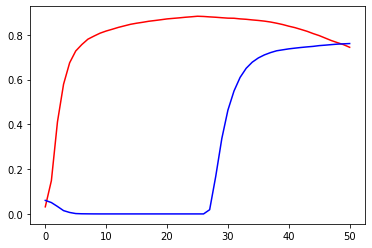

In [11]:
# Plot accuracy over time
plt.figure()
plt.plot(accuracies, color='r')
plt.plot(f_accuracies, color='b')
plt.show()

In [12]:
print('Accuracy for task #2 after training for task #2: {:.5f}'.format(
    accu(ewc.model, f_test_loader, target_offset=10)
))

Accuracy for task #2 after training for task #2: 0.76090


In [13]:
print('Accuracy for task #1 after training for task #2: {:.5f}'.format(
    accu(ewc.model, test_loader)
))

Accuracy for task #1 after training for task #2: 0.74420
